In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set current directory
# current_directory = os.getcwd()
# train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Train")
# test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Test")

current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")





In [ ]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='binary'
)

In [ ]:
# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x





In [ ]:
# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))



In [ ]:
# Load VGG-16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze VGG-16 layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG-16 base
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
vgg_model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Ensemble model
cnn_output = cnn_model.output
vgg_output = vgg_model(base_model.output)
ensemble_concat = Concatenate()([cnn_output, vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)

# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ensemble model
history = ensemble_model.fit(
    [train_generator, train_generator],
    train_generator.classes,
    validation_data=([test_generator, test_generator], test_generator.classes),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_steps=test_generator.samples // test_generator.batch_size,
    verbose=2
)

# Evaluate ensemble model
test_loss, test_acc = ensemble_model.evaluate([test_generator, test_generator], test_generator.classes)
print(f'Test Accuracy: {test_acc*100}')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)




In [ ]:
# Ensemble model
vgg_output = base_model.output
ensemble_concat = Concatenate()([cnn_output, vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)

# Compile ensemble model


In [ ]:
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the ensemble model
history = ensemble_model.fit(
    [train_generator, vgg_output_train],
    train_generator.classes,
    validation_data=([test_generator, vgg_output_test], test_generator.classes),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_steps=test_generator.samples // test_generator.batch_size,
    verbose=2
)



In [ ]:
# Evaluate ensemble model
test_loss, test_acc = ensemble_model.evaluate([test_generator, vgg_output_test], test_generator.classes)
print(f'Test Accuracy: {test_acc*100}')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)

# Flatten VGG output
vgg_output_train_flattened = Flatten()(vgg_output_train)
vgg_output_test_flattened = Flatten()(vgg_output_test)



In [ ]:
# Ensemble model
flattened_cnn_output = tf.keras.layers.Flatten()(cnn_output)
reshaped_vgg_output = Reshape((-1,))(vgg_output_train)  # Reshape VGG output to match CNN output shape
ensemble_concat = Concatenate()([flattened_cnn_output, reshaped_vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)


In [ ]:
# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the ensemble model
history = ensemble_model.fit(
    train_generator,  # Pass the train_generator directly
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,  # Pass the test_generator directly
    validation_steps=test_generator.samples // test_generator.batch_size,
    verbose=2
)


In [ ]:
# Evaluate ensemble model
test_loss, test_acc = ensemble_model.evaluate([test_generator, vgg_input_test], test_generator.classes)
print(f'Test Accuracy: {test_acc*100}')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)

# Flatten VGG output
vgg_output_train_flattened = Flatten()(vgg_output_train)
vgg_output_test_flattened = Flatten()(vgg_output_test)




In [ ]:
# Ensemble model
flattened_cnn_output = tf.keras.layers.Flatten()(cnn_output)
reshaped_vgg_output = Reshape((-1,))(vgg_output_train_flattened)  # Reshape VGG output to match CNN output shape
ensemble_concat = Concatenate()([flattened_cnn_output, reshaped_vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)



In [ ]:
# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the ensemble model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    verbose=2
)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)

# Flatten VGG output
vgg_output_train_flattened = Flatten()(vgg_output_train)
vgg_output_test_flattened = Flatten()(vgg_output_test)

# Ensemble model
flattened_cnn_output = tf.keras.layers.Flatten()(cnn_output)
reshaped_vgg_output = Reshape((-1,))(vgg_output_train_flattened)  # Reshape VGG output to match CNN output shape
ensemble_concat = Concatenate()([flattened_cnn_output, reshaped_vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)

# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size

# Train the ensemble model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test_generator,
    validation_steps=validation_steps,
    verbose=2
)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)

# Flatten VGG output
vgg_output_train_flattened = Flatten()(vgg_output_train)
vgg_output_test_flattened = Flatten()(vgg_output_test)

# Ensemble model
flattened_cnn_output = tf.keras.layers.Flatten()(cnn_output)
reshaped_vgg_output = Reshape((-1,))(vgg_output_train_flattened)  # Reshape VGG output to match CNN output shape
ensemble_concat = Concatenate()([flattened_cnn_output, reshaped_vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)

# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define custom data generator
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, vgg_outputs, labels, batch_size):
        self.image_paths = image_paths
        self.vgg_outputs = vgg_outputs
        self.labels = labels
        self.batch_size = batch_size
        self.n = len(image_paths)

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_vgg_outputs = self.vgg_outputs[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = [preprocess_input(image.img_to_array(image.load_img(path, target_size=(224, 224)))) for path in batch_paths]
        images = np.array(images)
        
        return [images, batch_vgg_outputs], batch_labels

# Create custom data generators
train_custom_generator = CustomDataGenerator(train_generator.filepaths, vgg_output_train, train_generator.labels, batch_size=16)
test_custom_generator = CustomDataGenerator(test_generator.filepaths, vgg_output_test, test_generator.labels, batch_size=16)

# Train the ensemble model using custom data generators
history = ensemble_model.fit(
    train_custom_generator,
    steps_per_epoch=len(train_custom_generator),
    epochs=30,
    validation_data=test_custom_generator,
    validation_steps=len(test_custom_generator),
    verbose=2
)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/english_dataset1/Test")

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Preprocess input images for VGG model
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

# Preprocess input images for VGG model
vgg_input_train = preprocess_images(train_generator.filepaths)
vgg_input_test = preprocess_images(test_generator.filepaths)

# Get VGG model output
vgg_output_train = base_model.predict(vgg_input_train)
vgg_output_test = base_model.predict(vgg_input_test)

# Define CNN model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate CNN model
cnn_model = MyModel()

# Set input shape explicitly
_ = cnn_model(tf.keras.Input(shape=(200, 200, 3)))

# Reshape CNN output
cnn_output = Reshape((1, 1, -1))(cnn_model.output)

# Flatten VGG output
vgg_output_train_flattened = Flatten()(vgg_output_train)
vgg_output_test_flattened = Flatten()(vgg_output_test)

# Ensemble model
flattened_cnn_output = tf.keras.layers.Flatten()(cnn_output)
reshaped_vgg_output = Reshape((-1,))(vgg_output_train_flattened)  # Reshape VGG output to match CNN output shape
ensemble_concat = Concatenate()([flattened_cnn_output, reshaped_vgg_output])
ensemble_output = Dense(1, activation='sigmoid')(ensemble_concat)
ensemble_model = Model(inputs=[cnn_model.input, base_model.input], outputs=ensemble_output)

# Compile ensemble model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices(([vgg_output_train, train_generator.labels], train_generator))
test_dataset = tf.data.Dataset.from_tensor_slices(([vgg_output_test, test_generator.labels], test_generator))

# Train the ensemble model using datasets
history = ensemble_model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_steps=test_generator.samples // test_generator.batch_size,
    verbose=2
)


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Test")

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(200, 200),
                                                  batch_size=32,
                                                  class_mode='binary')

# Define Custom CNN Model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate and compile Custom CNN Model
custom_cnn_model = MyModel()
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Custom CNN Model
custom_cnn_history = custom_cnn_model.fit(train_generator,
                                          steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                          epochs=3,
                                          validation_data=test_generator,
                                          validation_steps=test_generator.samples // test_generator.batch_size,
                                          verbose=2)

# Define VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build VGG16-based model
vgg_model = models.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train VGG16-based Model
vgg_history = vgg_model.fit(train_generator,
                            steps_per_epoch=train_generator.samples // train_generator.batch_size,
                            epochs=3,
                            validation_data=test_generator,
                            validation_steps=test_generator.samples // test_generator.batch_size,
                            verbose=2)

# Obtain predictions from both models
custom_cnn_predictions = custom_cnn_model.predict(test_generator)
vgg_predictions = vgg_model.predict(test_generator)

# Combine predictions using averaging
ensemble_predictions = (custom_cnn_predictions + vgg_predictions) / 2

# Evaluate ensemble predictions
ensemble_loss, ensemble_accuracy = vgg_model.evaluate(test_generator, verbose=2)
print("Ensemble Model Accuracy:", ensemble_accuracy)


Found 5558 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


2024-02-22 20:09:54.524825: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-02-22 20:09:55.101399: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-02-22 20:09:55.411666: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.


Epoch 1/3


2024-02-22 20:09:56.258370: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-02-22 20:09:56.455007: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.


173/173 - 857s - loss: 1.6219 - accuracy: 0.5986 - val_loss: 0.6382 - val_accuracy: 0.6673 - 857s/epoch - 5s/step
Epoch 2/3
173/173 - 792s - loss: 0.5625 - accuracy: 0.7076 - val_loss: 0.5249 - val_accuracy: 0.7248 - 792s/epoch - 5s/step
Epoch 3/3
173/173 - 1097s - loss: 0.5255 - accuracy: 0.7336 - val_loss: 0.4722 - val_accuracy: 0.7722 - 1097s/epoch - 6s/step
Epoch 1/3
173/173 - 1200s - loss: 0.7499 - accuracy: 0.6361 - val_loss: 0.6083 - val_accuracy: 0.6850 - 1200s/epoch - 7s/step
Epoch 2/3
173/173 - 1574s - loss: 0.5518 - accuracy: 0.7246 - val_loss: 0.5213 - val_accuracy: 0.7823 - 1574s/epoch - 9s/step
Epoch 3/3
173/173 - 1580s - loss: 0.5283 - accuracy: 0.7403 - val_loss: 0.5193 - val_accuracy: 0.7742 - 1580s/epoch - 9s/step
63/63 - 303s - loss: 0.5186 - accuracy: 0.7756 - 303s/epoch - 5s/step
Ensemble Model Accuracy: 0.7756218910217285


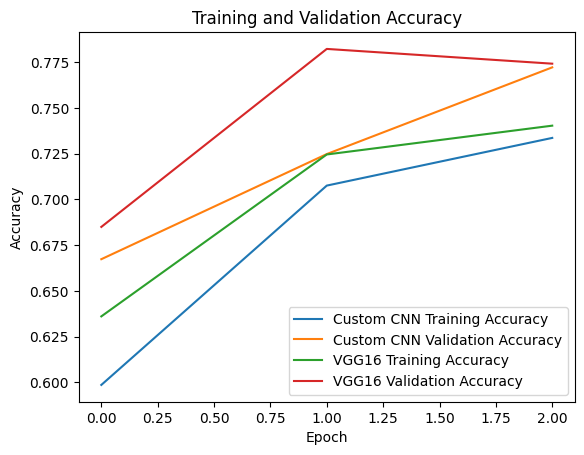

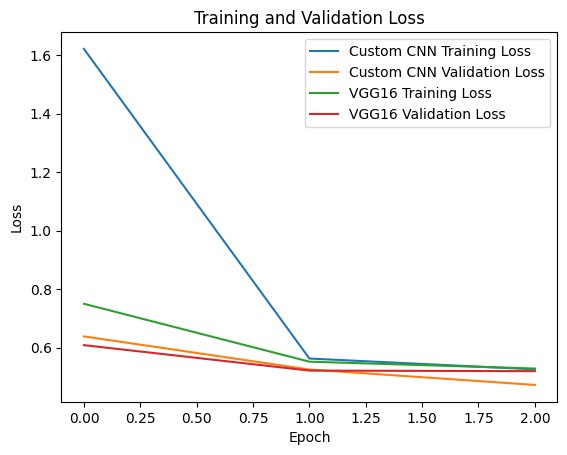

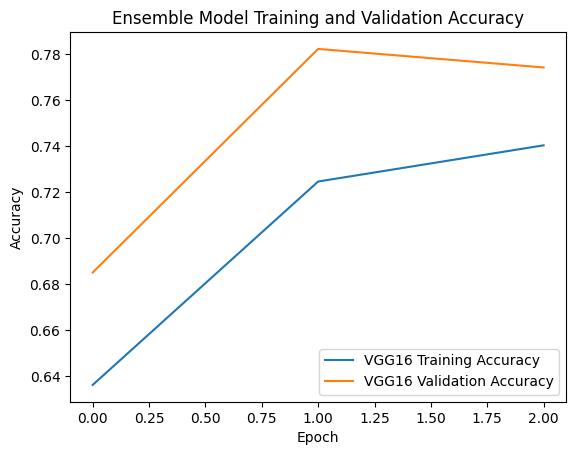

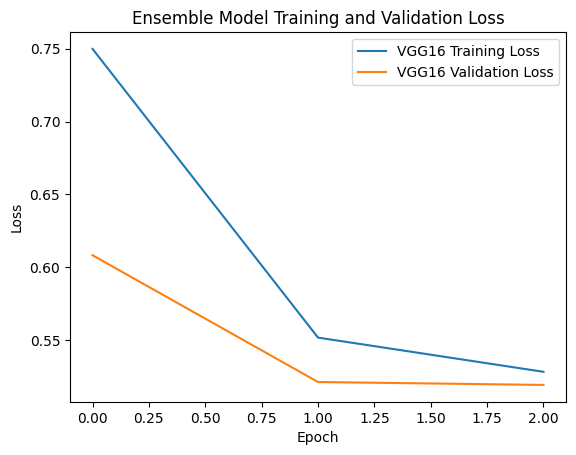

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(custom_cnn_history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(custom_cnn_history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(custom_cnn_history.history['loss'], label='Custom CNN Training Loss')
plt.plot(custom_cnn_history.history['val_loss'], label='Custom CNN Validation Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ensemble model accuracy and loss
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Ensemble Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Ensemble Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set directory paths
current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Train")
test_dir = os.path.join(current_directory, "/home/abhi/MP/sign_data/merged_dataset/Test")

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(200, 200),
                                                  batch_size=32,
                                                  class_mode='binary')

# Define Custom CNN Model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3))
        self.cnn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Instantiate and compile Custom CNN Model
custom_cnn_model = MyModel()
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Custom CNN Model
custom_cnn_history = custom_cnn_model.fit(train_generator,
                                          steps_per_epoch=train_generator.samples // train_generator.batch_size,
                                          epochs=30,
                                          validation_data=test_generator,
                                          validation_steps=test_generator.samples // test_generator.batch_size,
                                          verbose=2)

# Define VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build VGG16-based model
vgg_model = models.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train VGG16-based Model
vgg_history = vgg_model.fit(train_generator,
                            steps_per_epoch=train_generator.samples // train_generator.batch_size,
                            epochs=30,
                            validation_data=test_generator,
                            validation_steps=test_generator.samples // test_generator.batch_size,
                            verbose=2)

# Obtain predictions from both models
custom_cnn_predictions = custom_cnn_model.predict(test_generator)
vgg_predictions = vgg_model.predict(test_generator)

# Combine predictions using averaging
ensemble_predictions = (custom_cnn_predictions + vgg_predictions) / 2

# Evaluate ensemble predictions
ensemble_loss, ensemble_accuracy = vgg_model.evaluate(test_generator, verbose=2)
print("Ensemble Model Accuracy:", ensemble_accuracy)


2024-02-22 22:34:08.690996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-22 22:34:08.691060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 5558 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


2024-02-22 22:34:13.872653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 22:34:13.872977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-22 22:34:13.873057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-02-22 22:34:13.873115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-02-22 22:34:13.873172: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/30


2024-02-22 22:34:17.262087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.
2024-02-22 22:34:17.484012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233256448 exceeds 10% of free system memory.


173/173 - 958s - loss: 1.3220 - accuracy: 0.5206 - val_loss: 0.6916 - val_accuracy: 0.5323 - 958s/epoch - 6s/step
Epoch 2/30
173/173 - 1207s - loss: 0.6917 - accuracy: 0.5333 - val_loss: 0.6994 - val_accuracy: 0.4617 - 1207s/epoch - 7s/step
Epoch 3/30
173/173 - 815s - loss: 0.6914 - accuracy: 0.5161 - val_loss: 0.6916 - val_accuracy: 0.5358 - 815s/epoch - 5s/step
Epoch 4/30
173/173 - 1048s - loss: 0.6530 - accuracy: 0.6299 - val_loss: 0.6660 - val_accuracy: 0.5822 - 1048s/epoch - 6s/step
Epoch 5/30
173/173 - 835s - loss: 0.6184 - accuracy: 0.6531 - val_loss: 0.6339 - val_accuracy: 0.6295 - 835s/epoch - 5s/step
Epoch 6/30
173/173 - 850s - loss: 0.5527 - accuracy: 0.7059 - val_loss: 0.8187 - val_accuracy: 0.5776 - 850s/epoch - 5s/step
Epoch 7/30
173/173 - 864s - loss: 0.5111 - accuracy: 0.7463 - val_loss: 1.0092 - val_accuracy: 0.5771 - 864s/epoch - 5s/step
Epoch 8/30
173/173 - 925s - loss: 0.4903 - accuracy: 0.7590 - val_loss: 0.5011 - val_accuracy: 0.7303 - 925s/epoch - 5s/step
Epoch 9

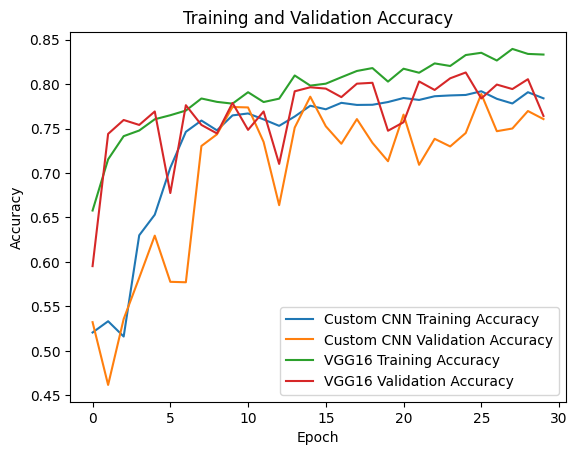

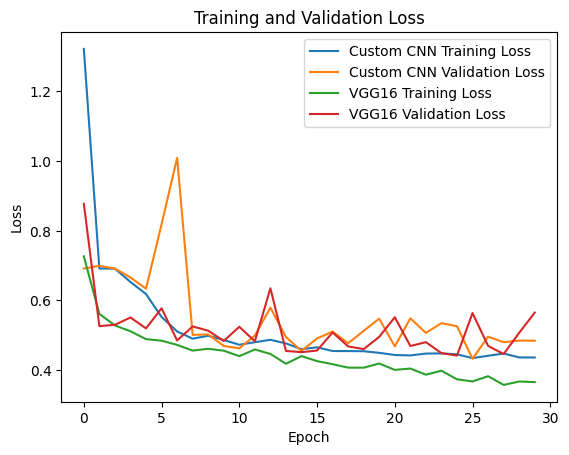

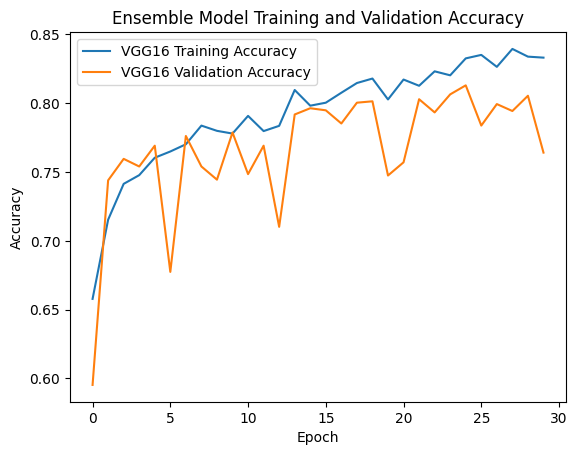

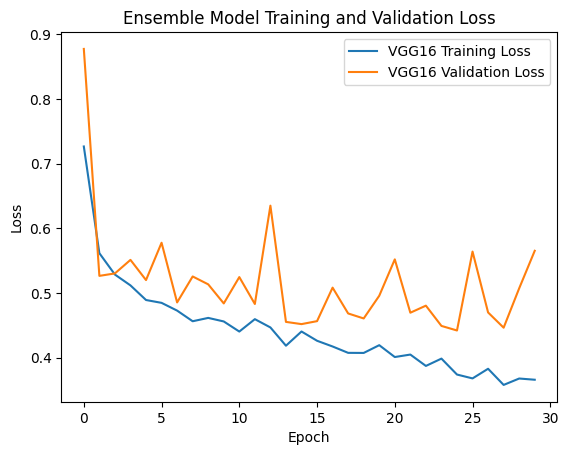

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(custom_cnn_history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(custom_cnn_history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(custom_cnn_history.history['loss'], label='Custom CNN Training Loss')
plt.plot(custom_cnn_history.history['val_loss'], label='Custom CNN Validation Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ensemble model accuracy and loss
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Ensemble Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Ensemble Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


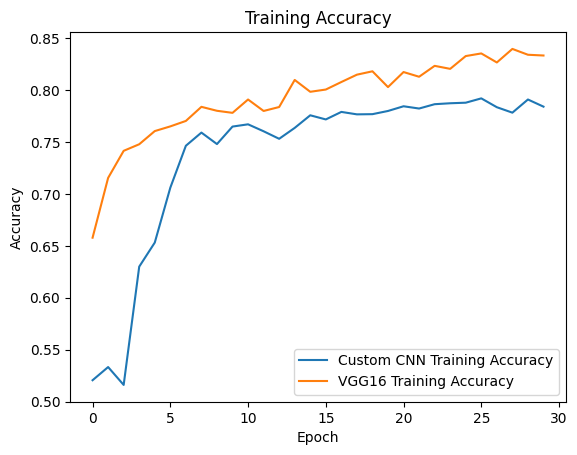

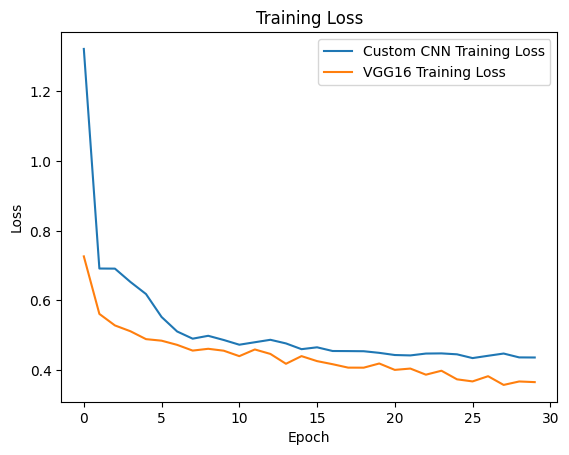

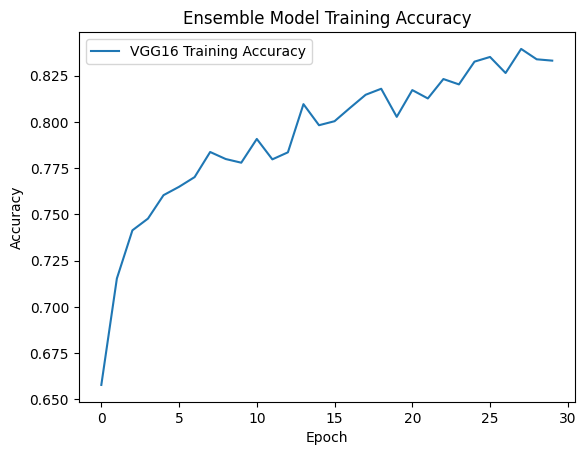

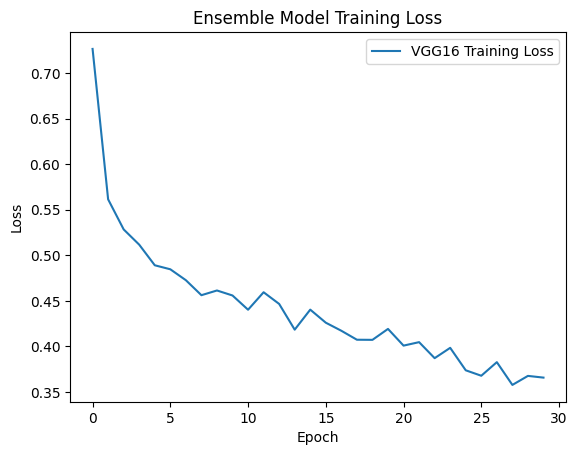

In [5]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(custom_cnn_history.history['accuracy'], label='Custom CNN Training Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.plot(custom_cnn_history.history['loss'], label='Custom CNN Training Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot ensemble model accuracy
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.title('Ensemble Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot ensemble model loss
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.title('Ensemble Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [1]:
# Define file paths for saving the model weights
custom_cnn_weights_path = os.path.join("/home/abhi/MP/", "custom_cnn_model_weights.h5")
vgg_weights_path = os.path.join("/home/abhi/MP/", "vgg_model_weights.h5")

# Save the weights of the custom CNN model
custom_cnn_model.save_weights(custom_cnn_weights_path)

# Save the weights of the VGG16 model
vgg_model.save_weights(vgg_weights_path)

print("Model weights saved successfully!")


NameError: name 'os' is not defined